<a href="https://colab.research.google.com/github/Aditi1203/CMPE-295/blob/master/Triple_loss_using_actual_y.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Aditi1203/CMPE-295.git

Cloning into 'CMPE-295'...
remote: Enumerating objects: 1054256, done.
remote: Total 1054256 (delta 0), reused 0 (delta 0), pack-reused 1054256
Receiving objects: 100% (1054256/1054256), 2.53 GiB | 16.72 MiB/s, done.
Resolving deltas: 100% (220384/220384), done.
Checking out files: 100% (717979/717979), done.


In [15]:
cd CMPE-295/anand_sandbox/

[Errno 2] No such file or directory: 'CMPE-295/anand_sandbox/'
/content/CMPE-295/anand_sandbox


In [0]:
import pandas as pd
import numpy as np
import cv2
import os
import imutils
import random
from keras.applications import VGG19, VGG16
from keras.applications.vgg19 import preprocess_input
from keras.applications.vgg16 import preprocess_input
from itertools import permutations
from keras.optimizers import SGD,Adam
from PIL import Image
import keras
from keras import backend as K
from keras import Sequential, losses, optimizers, Input, optimizers
from keras.layers import Input, Conv2D, Lambda, Dense, Flatten,MaxPooling2D, concatenate
from keras.models import Model, Sequential
from keras.layers import Input, Flatten, Lambda, Dense, Conv2D, MaxPool2D, MaxPooling2D, concatenate, Average, Flatten, Dropout, Activation
from keras.utils import to_categorical, plot_model,vis_utils
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.callbacks import TensorBoard, EarlyStopping
from keras.preprocessing.image import img_to_array
from skimage import io
import imutils
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pywt
from scipy import signal

In [0]:
def load_data(number_of_items=3):
    """
        number_of_items -> Number of items to return
        returns the data in a dictionary of images and labels.
    """
    path = "scalogram_module/Scalogram"
    path1= "scalogram_module/Scalogram/Cropped"
    data = [] 
    curated_data = {"label":[], "scalogram":[]}
    for subject_name in os.listdir(path)[:number_of_items]:
        if subject_name == ".DS_Store":
            number_of_items=number_of_items+1
            continue
        if subject_name  ==".ipynb_checkpoints":
            number_of_items=number_of_items+1
            continue
        print ("Going through subject:" + subject_name)
        base=os.path.basename(path+"/"+subject_name)
        labelData=os.path.splitext(base)[0]
        print(labelData)
        i=0
        for items in os.listdir(path+"/"+subject_name):
            if items == ".DS_Store":
                continue
            if items.endswith(".png"):
                try:
                    im2 = cv2.imread(path+"/"+subject_name+"/"+items)
                    crop_img = im2[30:20+235, 50:50+342]
                    im = cv2.resize(crop_img, (224,224)) # Changing into 80x80X3
                    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
                    curated_data['scalogram'].append(im)
                    curated_data['label'].append(labelData)
                except:
                      df = None  

    return curated_data

In [18]:
data = load_data(number_of_items=4)

Going through subject:person_228
person_228
Going through subject:person_108
person_108
Going through subject:person_118
person_118
Going through subject:person_109
person_109


In [19]:
print(data['scalogram'][0].shape)
print(len(data['scalogram']))

(224, 224)
4044


In [20]:
len(data['label'])

4044

In [21]:
data_array=np.array(data['scalogram'])
labels=np.array(data['label'])
print("Data shape:{}".format(data_array.shape))
print("Labels shape:{}".format(labels.shape))

Data shape:(4044, 224, 224)
Labels shape:(4044,)


In [0]:
data_array = data_array /  1/255

In [23]:
encoder = LabelEncoder()
encoder.fit(labels)
labels = encoder.transform(labels)
print("Encoded Labels shape:{} value:{}".format(labels.shape,labels))

Encoded Labels shape:(4044,) value:[3 3 3 ... 1 1 1]


In [24]:
x_train, x_test, y_train,  y_test=train_test_split(data_array, labels, test_size=0.2, random_state=2)
print("Shapes:")
print("Train Data:{}".format(x_train.shape))
print("Train Label:{}".format(y_train.shape))
print("Test Data:{}".format(x_test.shape))
print("Test Label:{}".format(y_test.shape))

Shapes:
Train Data:(3235, 224, 224)
Train Label:(3235,)
Test Data:(809, 224, 224)
Test Label:(809,)


In [25]:
x_train_master = np.expand_dims(x_train, 3)
x_test_master = np.expand_dims(x_test, 3)
print(x_train.shape, x_test.shape)

(3235, 224, 224) (809, 224, 224)


In [26]:
y_train_master = y_train.flatten()
y_test_master = y_test.flatten()
print(y_train_master.shape,y_test_master.shape)

(3235,) (809,)


In [27]:
shape=x_train.shape
dim_x = shape[1]
dim_y = shape[2]
print("Dimension of Scalogram Image: {}*{}".format(dim_x,dim_y ))

Dimension of Scalogram Image: 224*224


In [0]:
num_train_per_class = 1
n_epochs = 10

In [0]:
def generate_triplets(dataset, label, sample_per_class=20):
    x, y = None, None
    for i in set(label):
        pos_indices = np.argwhere(label == i)[:,0]
        print(len(pos_indices))
        neg_indices = np.argwhere(label != i)[:,0]

        # print("pos indices: {}, neg_indices: {}".format(pos_indices.shape, neg_indices.shape))
        choice_anchor = np.random.choice(pos_indices.shape[0], sample_per_class, replace=True)
        choice_anchor = pos_indices[choice_anchor]

        choice_pos = np.random.choice(pos_indices.shape[0], sample_per_class, replace=True)
        choice_pos = pos_indices[choice_pos]

        choice_neg = np.random.choice(neg_indices.shape[0], sample_per_class, replace=True)
        choice_neg = neg_indices[choice_neg]

        sub_x_anc = dataset[choice_anchor]

        sub_x_pos = dataset[choice_pos]

        sub_x_neg = dataset[choice_neg]


        if(x is None):
            x = [(sub_x_anc), (sub_x_pos), (sub_x_neg)]
            y = [label[choice_anchor], label[choice_pos], label[choice_neg]]
        else:
            x[0] = np.vstack((x[0], (sub_x_anc)))
            x[1] = np.vstack((x[1], (sub_x_pos)))
            x[2] = np.vstack((x[2], (sub_x_neg)))

            y[0] = np.hstack((y[0].flatten(), label[choice_anchor].flatten()))
            y[1] = np.hstack((y[1].flatten(), label[choice_pos].flatten()))
            y[2] = np.hstack((y[2].flatten(), label[choice_neg].flatten()))
            # y[0] = np.vstack((y[0].flatten(), label[choice_anchor].flatten()))
            # y[1] = np.vstack((y[1].flatten(), label[choice_pos].flatten()))
            # y[2] = np.vstack((y[2].flatten(), label[choice_neg].flatten()))

    return x, y

In [30]:
train_x, train_y = generate_triplets(x_train_master, y_train_master)

687
931
851
766


In [31]:
print(y_train_master)

[1 2 3 ... 2 2 1]


In [33]:
print(len(train_x),train_x[0].shape, len(train_y))
      
print("Anchor labels:{}".format(train_y[0]))
print("Positive labels:{}".format(train_y[1]))
print("Negative labels:{}".format(train_y[2]))

3 (80, 224, 224, 1) 3
Anchor labels:[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3]
Positive labels:[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3]
Negative labels:[2 3 1 1 1 3 1 3 1 2 2 2 2 3 3 1 2 1 3 1 3 0 0 2 2 3 2 2 2 2 2 2 2 2 3 0 0
 3 3 0 3 3 0 3 0 1 0 1 1 1 3 3 1 3 0 0 1 3 3 0 0 0 2 1 0 1 1 2 2 2 0 1 2 0
 2 1 1 2 0 2]


In [0]:
def visualize_data(data, n):
    n = min(len(data[0]), n)
    random_choices = np.random.choice(len(data[0]),n, replace=True)
    fig, ax = plt.subplots(n, 3,figsize=(10,40))
    anc, pos, neg = data
    for i,ch in enumerate(random_choices):
        ax[i, 0].imshow(np.squeeze(anc[ch] ))
        ax[i, 1].imshow(np.squeeze(pos[ch] ))
        ax[i, 2].imshow(np.squeeze(neg[ch] ))


        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
        ax[i, 2].set_axis_off()

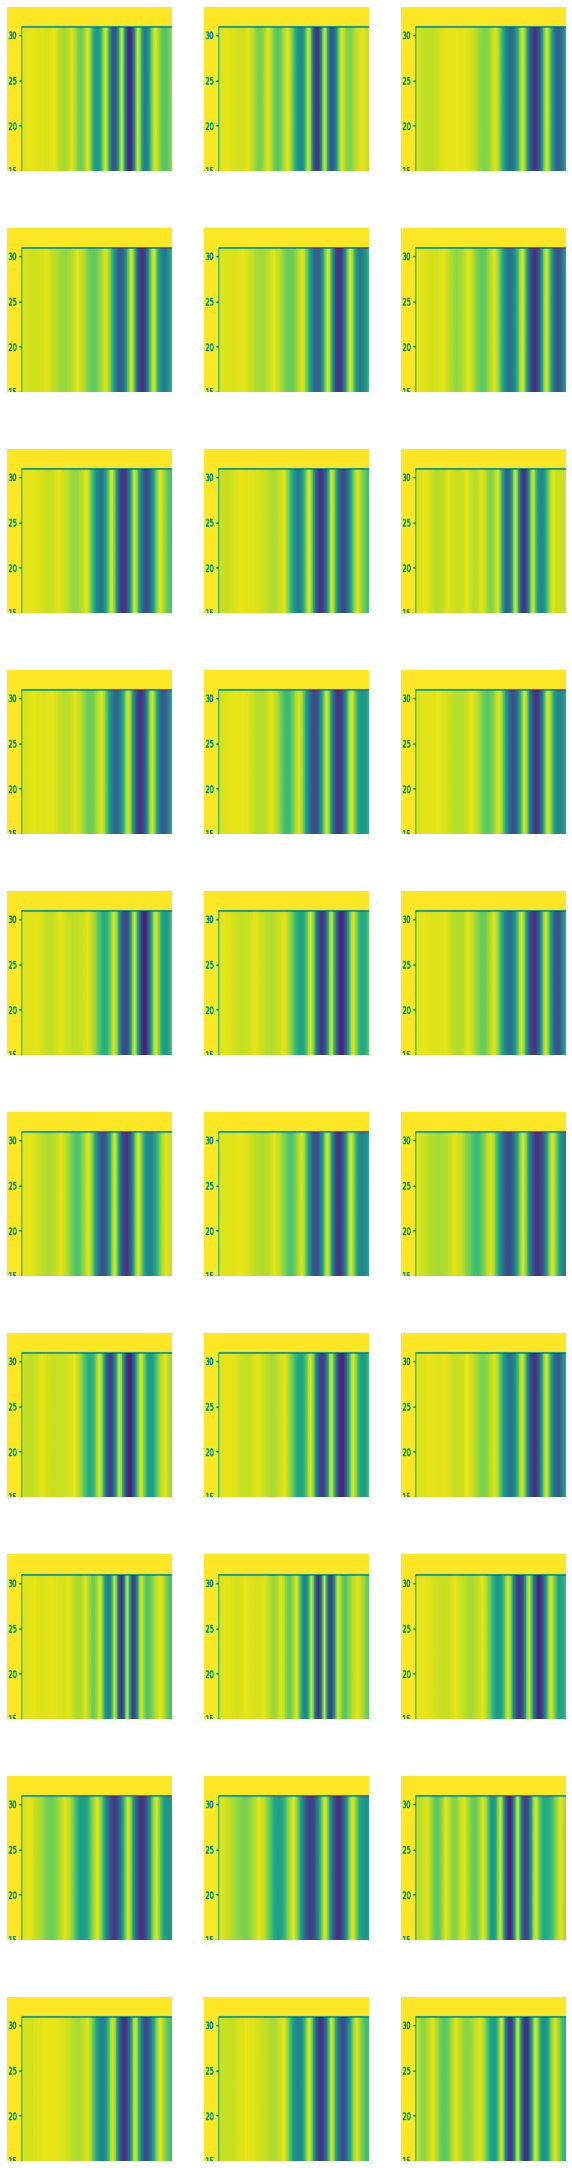

In [54]:
visualize_data(train_x, 10)

In [0]:
Case:2

In [36]:
num_train_per_class=100
num_test_per_class=30
train_x, train_y = generate_triplets(x_train_master, y_train_master, num_train_per_class)
test_x, test_y = generate_triplets(x_test_master, y_test_master,num_test_per_class)

687
931
851
766
144
247
212
206


In [37]:
print("Length of generated triplet for Train Data:{},{}".format(len(train_x),train_x[0].shape))
print("Length of generated triplet for Test Data:", len(test_x),test_x[0].shape)
print("Length of generated triplet for Train Label:{},{}".format(len(train_y),train_y[0].shape))
print("Length of generated triplet for Test Label:", len(test_y),test_y[0].shape)

Length of generated triplet for Train Data:3,(400, 224, 224, 1)
Length of generated triplet for Test Data: 3 (120, 224, 224, 1)
Length of generated triplet for Train Label:3,(400,)
Length of generated triplet for Test Label: 3 (120,)


In [0]:
def triplet_loss(inputs, dist='euclidean', margin='maxplus'):
    print("loss calculation")
    alpha=0.4
    anchor, positive, negative = inputs
    positive_distance = K.square(anchor - positive)
    negative_distance = K.square(anchor - negative)
    
    positive_distance = K.sqrt(K.sum(positive_distance, axis=-1, keepdims=True))
    negative_distance = K.sqrt(K.sum(negative_distance, axis=-1, keepdims=True))
    loss = positive_distance - negative_distance
    
    if margin == 'maxplus':
        loss = K.maximum(0.0, alpha + loss)
   
    return loss

In [0]:
def get_embedding_model(input_shape, embedding_dim):
    _input = Input(shape=input_shape)
    in_dims=input_shape
    x = Flatten()(_input)
    # x = Dense(embedding_dim * 4,activation="relu")(x)
    x = Dense(embedding_dim * 2, activation='relu')(x)
    x = Dense(embedding_dim)(x)
    return Model(_input, x)

In [0]:
def network_model(input_shape, triplet_margin=.3, embedding_dim=50):
    """
        Model architecture
    """
    
    # Defining tensors for the triplet of input images
    anchor_input = Input(input_shape, name="anchor_input")
    positive_input = Input(input_shape, name="positive_input")
    negative_input = Input(input_shape, name="negative_input")
    
    # Convolutional Neural Network (same from earlier)
    embedding_model = get_embedding_model(input_shape, embedding_dim)
    
    # Generate the embedding outputs 
    encoded_anchor = embedding_model(anchor_input)
    encoded_positive = embedding_model(positive_input)
    encoded_negative = embedding_model(negative_input)
    
    inputs = [anchor_input, positive_input, negative_input]
    outputs = [encoded_anchor, encoded_positive, encoded_negative]
    
    # Connect the inputs with the outputs
    triplet = Model(inputs=inputs,outputs=outputs)
    
    triplet.add_loss((triplet_loss(outputs, dist='euclidean', margin='maxplus')))
    
    # return the model
    return embedding_model, triplet

In [41]:
embedding_model, triplet = network_model((224,224,1), triplet_margin=.3, embedding_dim=150)
print("here")
triplet.compile(loss=None, optimizer=Adam(0.0001))

loss calculation
here


/usr/local/lib/python3.6/dist-packages/keras/engine/training_utils.py:819: UserWarning: Output model_1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_1.
  'be expecting any data to be passed to {0}.'.format(name))


In [44]:
n_epochs=10
history = triplet.fit(train_x, shuffle=True, batch_size=32,
                              validation_split=.1, epochs=n_epochs)

Train on 360 samples, validate on 40 samples
Epoch 1/10
360/360 [==============================] - 1s 2ms/step - loss: 0.0134 - val_loss: 0.5182
Epoch 2/10
360/360 [==============================] - 1s 2ms/step - loss: 0.0146 - val_loss: 0.6031
Epoch 3/10
360/360 [==============================] - 1s 2ms/step - loss: 0.0102 - val_loss: 0.5196
Epoch 4/10
360/360 [==============================] - 1s 2ms/step - loss: 0.0000e+00 - val_loss: 0.5690
Epoch 5/10
360/360 [==============================] - 1s 2ms/step - loss: 0.0018 - val_loss: 0.5688
Epoch 6/10
360/360 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.4420
Epoch 7/10
360/360 [==============================] - 1s 2ms/step - loss: 0.0034 - val_loss: 0.3933
Epoch 8/10
360/360 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.4229
Epoch 9/10
360/360 [==============================] - 1s 2ms/step - loss: 0.0015 - val_loss: 0.5862
Epoch 10/10
360/360 [==============================

In [45]:
print(len(train_x), train_x[0].shape)

3 (400, 224, 224, 1)


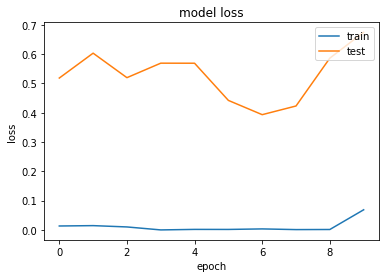

In [46]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [0]:
# Expected predictions from model on train_data(that is stacked)
train_embeds = embedding_model.predict(np.vstack((train_x[0], train_x[1], train_x[2])))

In [0]:
# Get the embeddings of the images
def get_image_embedding(test_model, input):
  train_data_v_stack=np.vstack((input[0], input[1], input[2]))
  train_embeds = test_model.predict(train_data_v_stack)
  return train_embeds


In [53]:
train_embeds=get_image_embedding(embedding_model, train_x)
print("Train Embeddings shape:{}".format(train_embeds.shape))
print(train_embeds[0].shape, train_embeds.shape)

Train Embeddings shape:(1200, 150)
(150,) (1200, 150)


In [60]:
train_data_v_stack = np.vstack((train_x[0], train_x[1], train_x[2]))
train_label_v_stack = np.vstack((train_y[0], train_y[1], train_y[2]))
print("Shape of vertical_stacked train data: {}".format(train_data_v_stack.shape))
print("Shape of vertical_stacked train label in form of [[],[],[]]: {}".format(train_label_v_stack.shape))
print("Labels of Anchor Image:{}".format(train_label_v_stack[0]))

Shape of vertical_stacked train data: (1200, 224, 224, 1)
Shape of vertical_stacked train label in form of [[],[],[]]: (3, 400)
Labels of Anchor Image:[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


Shape of vertical_stacked test data: (360, 224, 224, 1)
Shape of vertical_stacked test label in form of [[],[],[]]: (3, 120)
Labels of Image to test:[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3]


In [347]:
print("What is your claimed identity?")
claimed_label=input()
print(claimed_label)

What is your claimed identity?
0
0


In [0]:
from itertools import chain 
def get_k_template_values(label):
  label=int(label)
  target_label=np.argwhere(train_label_v_stack[0]==label)
  # List of list format.So need to change into single list using chain
  target_label = list(chain.from_iterable(target_label)) 
  print(target_label)

  k_template_value=[]
  for value in target_label:
    k_template_value.append(train_embeds[value])
  print("K templates, Value of k:{}, template shape:{}".format(len(k_template_value), len(k_template_value[0])))
  return k_template_value

In [353]:
k_template_value=get_k_template_values(claimed_label)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
K templates, Value of k:100, template shape:150


In [354]:
test_data_v_stack=np.vstack((test_x[0], test_x[1], test_x[2]))
test_label_v_stack=np.vstack((test_y[0], test_y[1], test_y[2]))
print("Shape of vertical_stacked test data: {}".format(test_data_v_stack.shape))
print("Shape of vertical_stacked test label in form of [[],[],[]]: {}".format(test_label_v_stack.shape))
print("Labels of Image to test:{}".format(test_label_v_stack[0]))

Shape of vertical_stacked test data: (360, 224, 224, 1)
Shape of vertical_stacked test label in form of [[],[],[]]: (3, 120)
Labels of Image to test:[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3]


In [361]:
print("Select any label!")
print(set(test_label_v_stack[0]))
real_identity = input()
print("Input Value:", real_identity)


# claimed_identity = 2

Select any label!
{0, 1, 2, 3}
0
Input Value: 0


In [362]:
# test_label=np.argwhere(test_label_v_stack[0]==2)
test_label=np.argwhere(test_label_v_stack[0]==int(real_identity))
test_label = list(chain.from_iterable(test_label)) 
# Multiple values of the same label in test_data, so we will select any random one
print(test_label)
print(random_test_label)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
30


In [363]:
# test_segment=None
random_test_label=test_label[0]
random_test_data=(test_data_v_stack[random_test_label]).reshape(1,224,224,1)
print("Corresponding image shape:", random_test_data.shape)
test_embeds = embedding_model.predict(random_test_data)
print("Shape of test template:{}".format(test_embeds.shape))
test_segment=test_embeds

Corresponding image shape: (1, 224, 224, 1)
Shape of test template:(1, 150)


In [0]:
def dissimilar_score(test_template, stored_templates):
  minimum=None
  test_template=np.array(test_template)
  # print(type(test_template))
  for template in stored_templates:
    # print(np.var(template-test_template),2*(np.var(template)+np.var(test_template)))
    distance=(np.var(template-test_template))/2*(np.var(template)+np.var(test_template))
    if minimum==None:
      minimum=distance
    else:
      minimum=min(distance, minimum)
  return minimum

In [0]:
score=dissimilar_score(test_segment, k_template_value)

In [367]:
threshold=5
if score>threshold:
  print("You are not authenticated with dissimarity score:{}".format(score))
else:
  print("Authentication Successful! with dissimarity score:{}".format(score))
    

Authentication Successful! with dissimarity score:0.5607982885400133
